<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/InClass-3-prep/InClass_3_prep_DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In-Class \#3 Preparation: Decision Trees**
*Preparation for In-Class Assignment* 3 covering Decision Trees algorithms.

---



Course: Computation Machine Learning 2

Student: Mathias Schindler

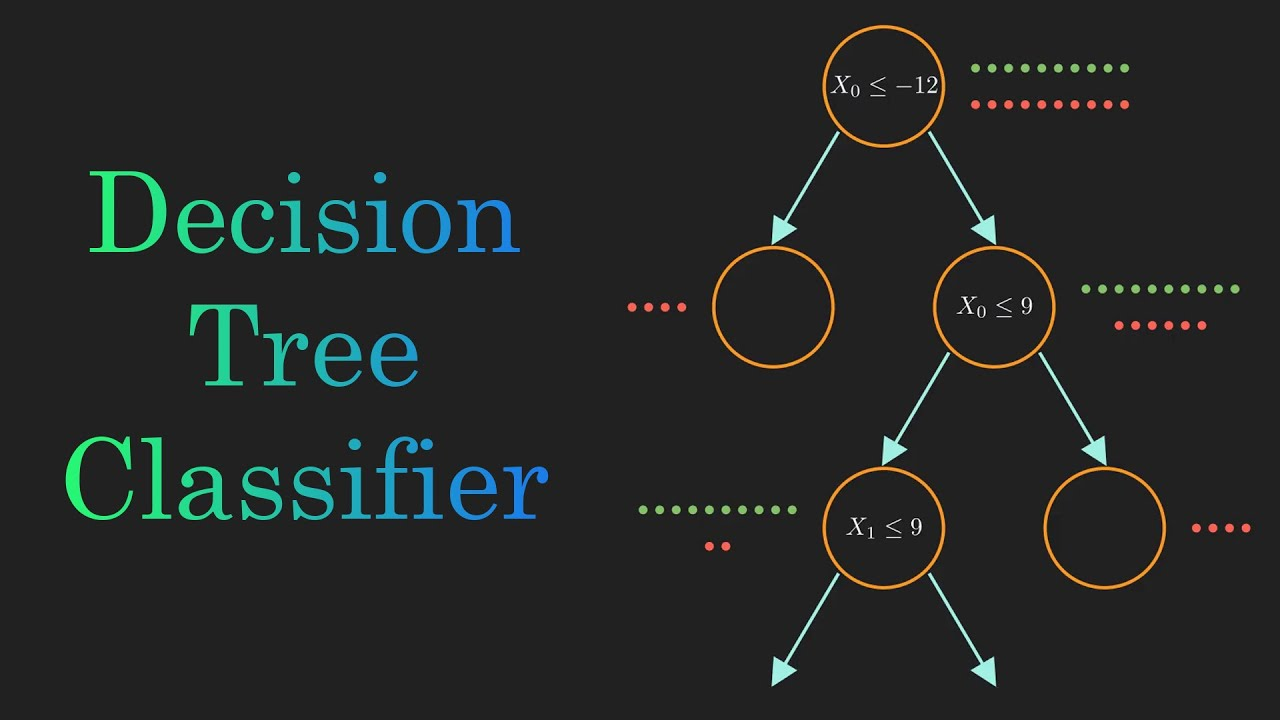

Structure of this notebooks (i.e. the sectioning) follows the ordinary evaluation criteria for In-Class Assignments.

NB: Notebook is partially based on [https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial](https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial).

## 0. Preamble

In [87]:
# clear everything
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [88]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Load packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBRegressor

In [90]:
from utils.helper_functions import *

In [91]:
from Project1_kNN.schindlerlib.plots import schindler_plots as my_plots
from Project1_kNN.schindlerlib.preproz import schindler_preproz as my_preproz
from Project1_kNN.schindlerlib.postest import schindler_postest as my_postest

print(dir(my_plots)); print(dir(my_preproz)); print(dir(my_postest))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_feat_importance_plot', 'make_nan_fig', 'make_roc_plot', 'make_scree_plot', 'missing_plot', 'np', 'p_hat_plot', 'pd', 'plot_confusion_matrix', 'plt', 'sns']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'construct_age_admit', 'datetime', 'np', 'pd', 'timedelta']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_multi_point_pred', 'np', 'pd', 'reweight', 'reweight_proba_multi']


# **1. Load Data**

## 1.1 Full Sample

In [92]:
path = '/content/drive/My Drive/--T2-CML2/InClass-submissions/InClass3-DecisionTrees/'

In [93]:
#Train data
data_train = pd.read_csv(path + 'prep_data/mimic_train.csv', index_col= 1)
#data_train = pd.read_csv(path + 'submit_data/', index_col= 1)
data_train.head()

,HOSPITAL_EXPIRE_FLAG,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55440,0,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
76908,0,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
95798,0,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
40708,0,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
28424,0,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [94]:
# Test dataset (to produce predictions)
X_test = pd.read_csv(path + 'prep_data/mimic_test_death.csv', index_col= 0)
#X_test = pd.read_csv(path + 'submit_data/', index_col= 0)
#data_test.head()

## 1.2 Random Sample

To quickly check that code runs, load data as 5% random sample.

In [95]:
#data_train, X_test = data_train.sample(frac = 0.05), X_test.sample(frac = 0.05),

# **2. Data Exploration**

## 2.1 Exploratory Analysis

In [96]:
# Set target
y = data_train['HOSPITAL_EXPIRE_FLAG']

X_train = data_train.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

In [97]:
# data shape
print('Shape (train): '+ str(X_train.shape) + ''); 
print('Shape (test): '+ str(X_test.shape) + '\n'); 

# inspect columns
print('Columns (train): \n' + str(X_train.columns) + '\n')
print('Columns (test): \n' + str(X_test.columns) + '\n')

# data types
print('Data Types (train): \n' + str(X_train.dtypes) + '\n')
print('Data Types (test): \n' + str(X_test.dtypes) )

Shape (train): (20885, 42)
Shape (test): (5221, 38)

Columns (train): 
Index(['hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB', 'DOD',
       'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

Columns (test): 
Index(['hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'R

In [98]:
# summary statistics
print('Summary stats: \n')
X_train.describe().applymap(lambda x: f"{x:0.2f}") #<- .applymap(...) for 2 decimals

#round(data.describe(),2)

Summary stats: 



,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.00,20885.00,18698.00,18698.00,18698.00,18677.00,18677.00,18677.00,18676.00,18676.00,18676.00,18699.00,18699.00,18699.00,18696.00,18696.00,18696.00,18388.00,18388.00,18388.00,18682.00,18682.00,18682.00,20632.00,20632.00,20632.00,20885.00,20885.00
mean,150082.40,250202.50,69.71,105.24,85.18,91.11,150.73,119.15,44.33,88.36,62.51,56.29,107.07,77.61,11.92,27.78,18.99,36.05,37.43,36.75,91.01,99.56,96.87,106.78,182.13,138.86,-51617.07,3.70
std,28898.48,28909.81,14.87,20.92,15.32,17.53,23.83,16.70,11.91,19.29,11.01,14.35,27.59,11.11,3.57,6.28,3.85,0.73,0.80,0.60,7.40,1.16,2.33,35.18,92.67,44.93,10686.40,5.18
min,100001.00,200001.00,2.00,39.00,34.71,5.00,46.00,46.00,4.00,27.00,17.00,1.00,29.00,25.76,1.00,12.00,9.29,15.00,30.80,30.67,1.00,57.00,47.67,2.00,42.00,42.00,-72740.27,0.06
25%,125157.00,225153.00,60.00,90.00,74.27,81.00,134.00,107.10,37.00,75.00,54.95,49.00,91.00,70.03,10.00,23.00,16.25,35.67,36.94,36.39,90.00,100.00,95.81,86.00,126.00,110.75,-60864.45,1.17
50%,150152.00,250452.00,69.00,103.00,84.13,90.00,148.00,116.90,44.00,86.00,61.42,57.00,102.00,76.29,12.00,27.00,18.38,36.11,37.33,36.73,92.00,100.00,97.14,102.00,161.00,128.67,-51561.70,2.02
75%,175017.00,275303.00,79.00,118.00,95.19,101.00,164.00,129.47,51.00,98.00,68.95,64.00,116.00,84.04,14.00,31.00,21.11,36.50,37.89,37.09,94.00,100.00,98.35,121.00,206.00,154.58,-42327.56,3.92
max,199999.00,299998.00,141.00,280.00,163.88,181.00,323.00,202.17,105.00,294.00,121.49,122.00,299.00,136.65,31.00,69.00,41.24,40.10,42.00,40.24,100.00,100.00,100.00,563.00,2440.00,771.90,-32157.49,101.74


AxesSubplot(0.125,0.125;0.775x0.755)
0    0.887718
1    0.112282
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64




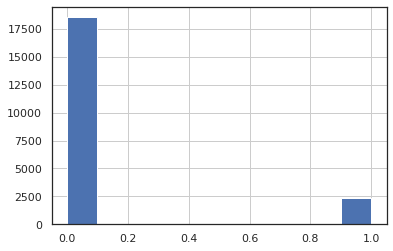

In [99]:
# distribution of target
print(y.hist() ); print(y.value_counts() / len(y) ); print('\n')

In [100]:
%%script false
# Distribution of features
plt.figure(figsize=(12,10))

plt.subplot(4, 2, 1); fig = data['IP_Mean'].hist(bins=20)
fig.set_xlabel('IP_Mean'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 2); fig = data['IP_Sd'].hist(bins=20); fig.set_xlabel('IP_Sd'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 3); fig = data['IP_Kurtosis'].hist(bins=20)
fig.set_xlabel('IP_Kurtosis')
fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 4); fig = data['IP_Skewness'].hist(bins=20); fig.set_xlabel('IP_Skewness'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 5); fig = data['DM-SNR Mean'].hist(bins=20); fig.set_xlabel('DM-SNR Mean'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 6); fig = data['DM-SNR Sd'].hist(bins=20); fig.set_xlabel('DM-SNR Sd'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 7); fig = data['DM-SNR Kurtosis'].hist(bins=20); fig.set_xlabel('DM-SNR Kurtosis'); fig.set_ylabel('Number of pulsar stars')
plt.subplot(4, 2, 8); fig = data['DM-SNR Skewness'].hist(bins=20); fig.set_xlabel('DM-SNR Skewness'); fig.set_ylabel('Number of pulsar stars')

#data.hist()

## 2.2 Univariate Distributions

In [101]:
num_feats = []
dataTypeObj = X_train.dtypes

# Save list of numerical features
for k in range(len(dataTypeObj)):
  if dataTypeObj[k] == np.int64:
    num_feats.append(dataTypeObj.index[k])
  elif dataTypeObj[k] == np.float64:
    num_feats.append(dataTypeObj.index[k])
  else:
    pass

print(num_feats)

['hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff', 'LOS']


In [102]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(24, 20)) # Size of the matrix plots

for i, col in enumerate(num_feats):
  #sns.kdeplot(x = col, data = X_train) 
  print(i); print(col)

0
hadm_id
1
icustay_id
2
HeartRate_Min
3
HeartRate_Max
4
HeartRate_Mean
5
SysBP_Min
6
SysBP_Max
7
SysBP_Mean
8
DiasBP_Min
9
DiasBP_Max
10
DiasBP_Mean
11
MeanBP_Min
12
MeanBP_Max
13
MeanBP_Mean
14
RespRate_Min
15
RespRate_Max
16
RespRate_Mean
17
TempC_Min
18
TempC_Max
19
TempC_Mean
20
SpO2_Min
21
SpO2_Max
22
SpO2_Mean
23
Glucose_Min
24
Glucose_Max
25
Glucose_Mean
26
Diff
27
LOS


<Figure size 1728x1440 with 0 Axes>

## 2.3 Multivariate Distribution

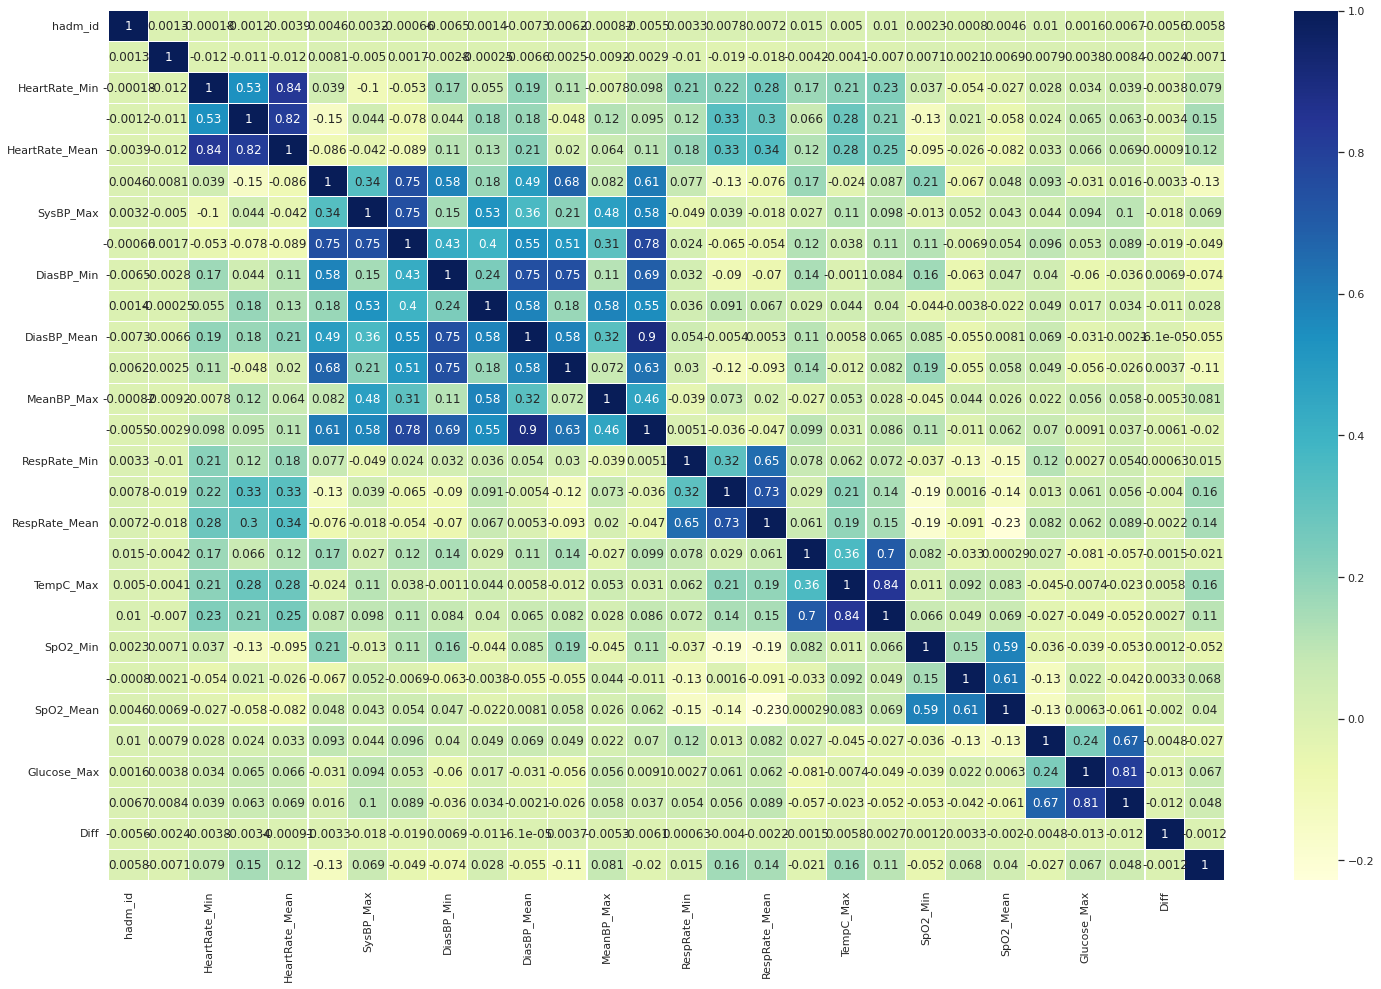

In [103]:
# Heatmap
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(X_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap="YlGnBu", 
            linecolor='white', 
            annot=True)

fig = plt.gcf()
fig.set_size_inches(25, 16)

## 2.4 Missing Values Imputation

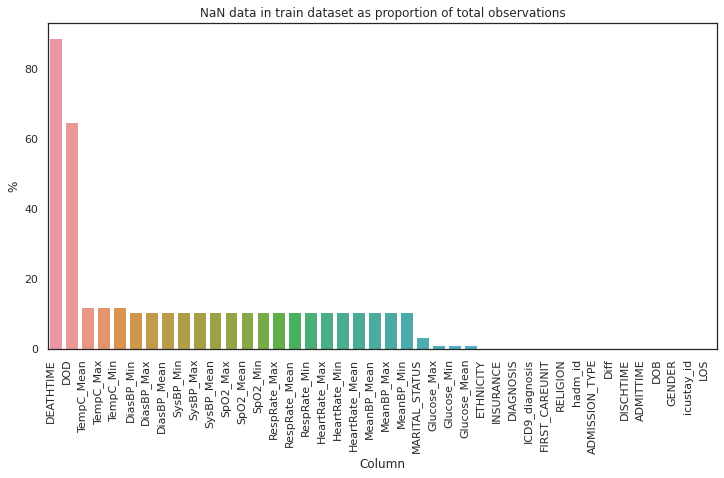

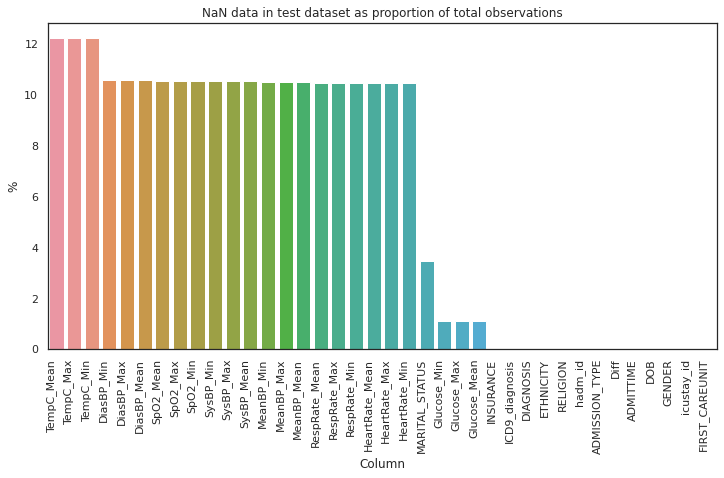

In [104]:
# Inspect missing values
my_plots.missing_plot(X_train, 'train'); my_plots.missing_plot(X_test, 'test')

Imputing NaNs with mean in order to preserve same number of rows that is necessary for exporting predictions and Kaggle.

In [105]:
train_mean = X_train.mean()

X_train_nona = X_train.fillna(train_mean)
X_test_nona = X_test.fillna(train_mean)

#Check: 
print(X_train_nona.isna().any() ); print(X_test_nona.isna().any() )

hadm_id           False
icustay_id        False
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
GENDER            False
DOB               False
DOD                True
ADMITTIME         False
DISCHTIME         False
DEATHTIME          True
Diff              False
ADMISSION_TYPE    False
INSURANCE         False
RELIGION          False
MARITAL_STATUS     True
ETHNICITY         False
DIAGNOSIS         False
ICD9_diagnosis    False
FIRST_CAREUNIT    False
LOS             

In [106]:
# Drop if still missing (prob bc string)
drop_var = ['DOD', 'DEATHTIME', 'MARITAL_STATUS']

X_train_nona = X_train_nona.drop(drop_var, axis = 1)
X_test_nona = X_test_nona.drop(['MARITAL_STATUS'], axis = 1)

#Check 
print(X_train_nona.isna().any() ); print(X_test_nona.isna().any() )

hadm_id           False
icustay_id        False
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
GENDER            False
DOB               False
ADMITTIME         False
DISCHTIME         False
Diff              False
ADMISSION_TYPE    False
INSURANCE         False
RELIGION          False
ETHNICITY         False
DIAGNOSIS         False
ICD9_diagnosis    False
FIRST_CAREUNIT    False
LOS               False
dtype: bool
hadm_id           False
icustay_id        False
Hear

In [107]:
%%script false
plt.figure(figsize=(12,10))

plt.subplot(4, 2, 1); fig = data.boxplot(column='IP_Mean'); fig.set_title(''); fig.set_ylabel('IP_Mean')
plt.subplot(4, 2, 2); fig = data.boxplot(column='IP_Sd'); fig.set_title(''); fig.set_ylabel('IP_Sd')
plt.subplot(4, 2, 3); fig = data.boxplot(column='IP_Kurtosis'); fig.set_title(''); fig.set_ylabel('IP_Kurtosis')
plt.subplot(4, 2, 4); fig = data.boxplot(column='IP_Skewness'); fig.set_title(''); fig.set_ylabel('IP_Skewness')
plt.subplot(4, 2, 5); fig = data.boxplot(column='DM-SNR Mean'); fig.set_title(''); fig.set_ylabel('DM-SNR Mean')
plt.subplot(4, 2, 6); fig = data.boxplot(column='DM-SNR Sd'); fig.set_title(''); fig.set_ylabel('DM-SNR Sd')
plt.subplot(4, 2, 7); fig = data.boxplot(column='DM-SNR Kurtosis'); fig.set_title(''); fig.set_ylabel('DM-SR Kurtosis')
plt.subplot(4, 2, 8); fig = data.boxplot(column='DM-SNR Skewness'); fig.set_title(''); fig.set_ylabel('DM-SNR Skewness')

# **3. Preprocessing**

## 3.1 Keep Only Numerical Data

For inclass I will only use numerical data as I suspect runtime will be too long with one-hot encoding due to many categorical features and hence high dimensional data.

In [108]:
# Numerical Data
cat_feat_lst = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT", "DOB", "ADMITTIME"]

X_train_num = X_train_nona.drop(cat_feat_lst + ['DISCHTIME'], axis = 1)
X_test_num = X_test_nona.drop(cat_feat_lst, axis = 1)

#check 
print(X_train_num.dtypes); print(X_test_num.dtypes)

hadm_id             int64
icustay_id          int64
HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float64
DiasBP_Mean       float64
MeanBP_Min        float64
MeanBP_Max        float64
MeanBP_Mean       float64
RespRate_Min      float64
RespRate_Max      float64
RespRate_Mean     float64
TempC_Min         float64
TempC_Max         float64
TempC_Mean        float64
SpO2_Min          float64
SpO2_Max          float64
SpO2_Mean         float64
Glucose_Min       float64
Glucose_Max       float64
Glucose_Mean      float64
Diff              float64
LOS               float64
dtype: object
hadm_id             int64
icustay_id          int64
HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float6

In [109]:
# Checking if same columns / dimensions
train_cols = X_train_num.columns
test_cols = X_test_num.columns

print('In train but not test: ' + str(train_cols.difference(test_cols)) )
print('In test but not train: ' + str(test_cols.difference(train_cols)) )

In train but not test: Index(['LOS'], dtype='object')
In test but not train: Index([], dtype='object')


In [110]:
X_train_num = X_train_num.drop(['LOS'], axis = 1)

## 3.1 Standardization

In [111]:
# save columns
cols = X_train_num.columns

In [112]:
scl_train = X_train_num
scl_test = X_test_num

# Instantiate
scl = StandardScaler()

# Fit
scl.fit(scl_train)

# Transform
scl_train = scl.transform(scl_train)
scl_test = scl.transform(scl_test)

# Format
scl_train, scl_test = pd.DataFrame(scl_train, columns= cols), pd.DataFrame(scl_test, columns= cols)

In [113]:
scl_train.head()
#scl_test.head()

,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
0,1.580938,-0.755661,1.371353e+00,2.008463,2.474416e+00,-1.032036e+00,-1.052701e+00,-7.951633e-01,-0.206698,0.089886,-1.284776e-01,1.993805e-01,-5.008976e-01,-2.915794e-01,0.911554,3.736866e-01,9.230392e-01,-1.368516e+00,-6.453202e-01,-1.185847e+00,-0.143967,-5.067807e-01,-5.109988e-01,0.120638,0.519763,0.490860,-0.968050
1,-0.828659,-1.010010,-4.766311e-01,0.240459,-4.182947e-01,-1.273002e-01,-1.318917e+00,-7.858952e-01,0.414856,-0.787468,2.133819e-01,1.257251e-01,-8.840143e-01,-2.671844e-01,0.319788,-1.141409e+00,-8.036251e-01,4.106957e-01,-1.089446e+00,-4.936007e-01,0.999204,4.048877e-01,9.934597e-01,-0.108167,-0.859167,-0.802892,0.792698
2,-0.464998,1.595085,8.027428e-01,-0.365714,4.491223e-01,-1.876159e-01,-5.646396e-01,-4.026771e-01,0.059682,-1.171310,-5.465059e-01,5.676576e-01,-7.307676e-01,-4.489295e-01,0.319788,-1.141409e+00,-8.472305e-01,5.724422e-01,-7.193412e-01,-1.502029e-01,1.284997,4.048877e-01,1.419993e+00,0.721252,1.779258,1.764030,0.899025
3,-1.646403,-0.160693,4.473612e-01,1.149718,9.436496e-01,-4.288789e-01,-6.977473e-01,-7.707219e-01,-1.272218,0.035051,-1.982988e+00,-6.108291e-01,-5.008976e-01,-1.409916e+00,0.023905,1.215407e+00,2.137552e+00,4.106957e-01,2.759647e+00,1.910184e+00,-1.858724,4.048877e-01,-8.071218e-01,0.034836,-0.468289,-0.310271,0.751599
4,-0.787098,-0.862064,-1.010055e-15,0.000000,-1.960981e-14,-8.571382e-16,-1.261050e-15,1.259702e-14,0.000000,0.000000,3.480397e-14,5.233532e-16,-5.444416e-16,-3.378601e-14,0.000000,-5.980781e-16,4.877040e-15,4.033966e-13,-5.680271e-14,-1.756791e-13,0.000000,1.295559e-14,3.220123e-14,-0.279771,-0.490005,-0.578974,0.125892


# **$\pi$. PCA**

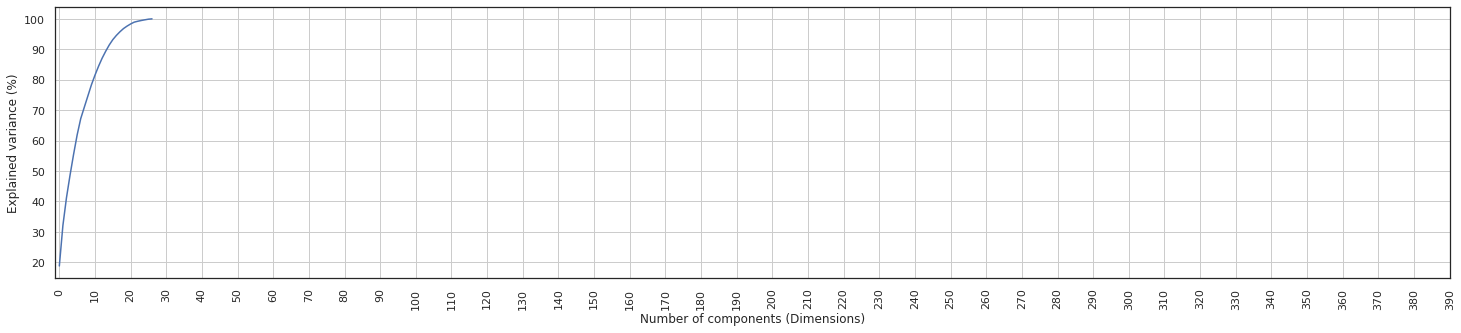

CPU times: user 645 ms, sys: 117 ms, total: 762 ms
Wall time: 622 ms


In [114]:
%%time
# Apply PCA to training data
pca = PCA(n_components=None)
pca.fit(scl_train)

# Make scree plot
my_plots.make_scree_plot(pca)


In [115]:
# Instantiate PCA with 30 components
#pca = PCA(n_components=30)
pca = PCA(n_components=10)

# Fit to training data
X_pca = pca.fit(scl_train)

# Transform train and test with the pipeline fittes on train data
X_pca_train, X_pca_test = pca.transform(scl_train), pca.transform(scl_test)

# pd.dataframes
X_pca_train = pd.DataFrame(X_pca_train, index = scl_train.index)
X_pca_test = pd.DataFrame(X_pca_test, index = scl_test.index)

# **4. Naïve Estimations, Naïve (Default Options)**

## 4.1 Decision Trees

In [116]:
%%time
#Set dfs and target to fit
df, target = scl_train, y


# Instantiate 
DT_model = DecisionTreeClassifier(criterion = 'gini', # 'gini' is default
                                 splitter = 'best', # 'best' is default
                                 min_samples_split = 2, # 2 is default
                                 min_samples_leaf = 1, # 1 is default
                                 min_weight_fraction_leaf = 0, # 0 is default
                                 min_impurity_decrease = 0 # 0 is default
                                 )      

# Fit to data
DT_model.fit(df, target)

CPU times: user 1.14 s, sys: 75.8 ms, total: 1.22 s
Wall time: 1.14 s


## 4.2 Random Forest

In [117]:
%%time
#Set dfs and target to fit
df, target = scl_train, y


# Instantiate 
RFC = RandomForestClassifier(n_estimators = 100, # default
                             criterion = 'gini', # default
                             min_samples_split = 2, # default
                             min_samples_leaf = 1, # default
                             min_weight_fraction_leaf = 0, # default
                             max_features = 'auto', # default
                             min_impurity_decrease = 0, # default
                             oob_score = False)      # default

# Fit to data
RFC.fit(df, target)

CPU times: user 11.8 s, sys: 20.4 ms, total: 11.9 s
Wall time: 11.8 s


## 4.3 AdaBoost

In [118]:
%%time
#Set dfs and target to fit
df, target = scl_train, y

# Instantiate 
ada = AdaBoostClassifier(n_estimators = 50, # default
                         learning_rate = 1.0, # default
                         base_estimator = None) # default


# Fit to data
ada.fit(df, target)

CPU times: user 2.73 s, sys: 15.6 ms, total: 2.74 s
Wall time: 2.73 s


## 4.4 GradientBoosting

In [119]:
%%time
#Set dfs and target to fit
df, target = scl_train, y

# Instantiate 
gbc = GradientBoostingClassifier(n_estimators = 100, # default
                                 subsample = 1.0, # default
                                 learning_rate = 0.1, # default
                                 criterion = 'friedman_mse', # default
                                 min_samples_split = 2, # default
                                 min_samples_leaf = 1, # default
                                 max_depth = 3, # default
                                 min_impurity_decrease = 0.0, # default
                                 max_features = None # default
                                 ) 


# Fit to data
gbc.fit(df, target)

CPU times: user 12.5 s, sys: 18.6 ms, total: 12.5 s
Wall time: 12.4 s


# **5. Feature Importance**

In [120]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

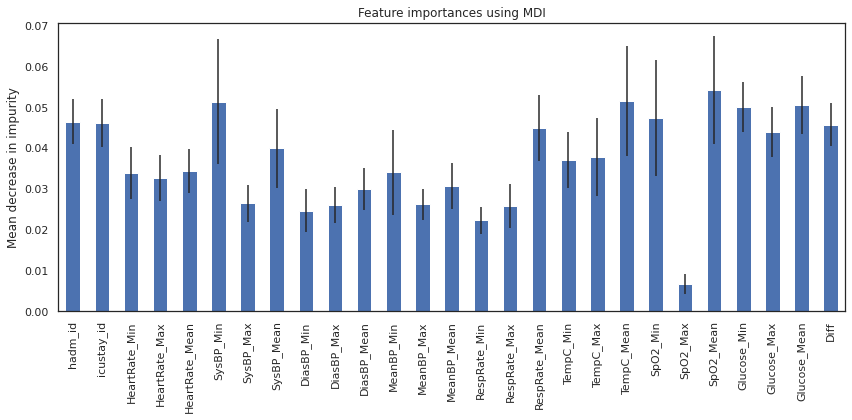

In [121]:
# Save feature names
feature_names = scl_train.columns

# Calculate importances 
importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)

# Plot importances
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(12, 6)
fig.tight_layout()

[Text(0, 0, '0.006661739837516411'),
 Text(0, 0, '0.02227546334509178'),
 Text(0, 0, '0.024646305564050466'),
 Text(0, 0, '0.025793348122672734'),
 Text(0, 0, '0.026043564517323613'),
 Text(0, 0, '0.02617190570633136'),
 Text(0, 0, '0.026416356047969086'),
 Text(0, 0, '0.029906398103086252'),
 Text(0, 0, '0.0307256130298665'),
 Text(0, 0, '0.03254507874015867'),
 Text(0, 0, '0.033864391348307724'),
 Text(0, 0, '0.03402788219833187'),
 Text(0, 0, '0.03434558235660647'),
 Text(0, 0, '0.03702563442620326'),
 Text(0, 0, '0.037850850164133004'),
 Text(0, 0, '0.03992015327344788'),
 Text(0, 0, '0.043860150207267544'),
 Text(0, 0, '0.0448303377824802'),
 Text(0, 0, '0.04568240668248108'),
 Text(0, 0, '0.046013248824295964'),
 Text(0, 0, '0.04642993844546294'),
 Text(0, 0, '0.04733520131682119'),
 Text(0, 0, '0.050093568535049655'),
 Text(0, 0, '0.050531137788818736'),
 Text(0, 0, '0.05133499709383499'),
 Text(0, 0, '0.051494840867479914'),
 Text(0, 0, '0.05417390567491063')]

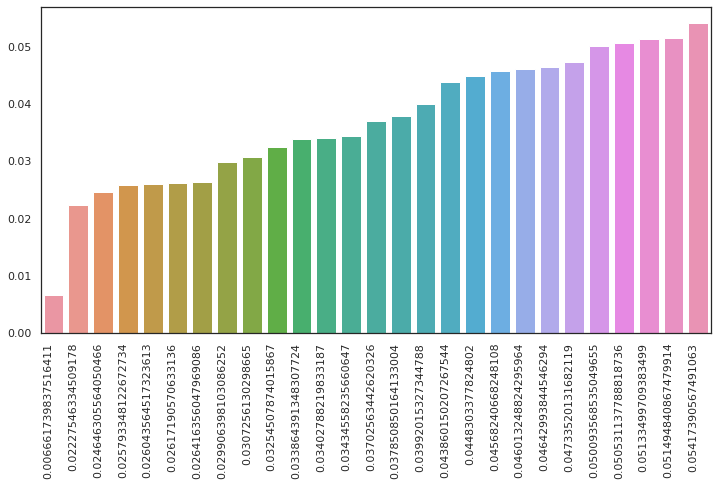

In [122]:
# try with seaborn
import warnings; warnings.filterwarnings("ignore")

feat_names = forest_importances.index.to_list()

plt.figure().set_size_inches(12, 6)
ax = sns.barplot(forest_importances, 
                 x = feat_names, 
                 y = forest_importances.values,
                 ci = "sd")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right')

# **6. Hyperparameter Optimization**

For demonstration purposes, I here run a `RandomizedSearchCV` using a 5\% random sample of the data. Unfortunately, I cannot get `AdaBoostClassifier` to run smoothly in the grid so I leave this for the extended assignment.

In [123]:
scl_train, scl_test, y = scl_train.sample(frac = 0.05), scl_test.sample(frac = 0.05), y.sample(frac = 0.05)

In [124]:
# 5% random sample datasets shape
print("Train shape: ", scl_train.shape, "\n"); print("Target shape: ", y.shape, "\n");
print("Test shape: ", scl_test.shape)

Train shape:  (1044, 27) 

Target shape:  (1044,) 

Test shape:  (261, 27)


In [125]:
%%time
df, target, df_test = scl_train, y, scl_test

# Set seed
#SEED = np.random.seed
SEED = 444


# models
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          #AdaBoostClassifier(),
         GradientBoostingClassifier()]


# models parameters
dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}
'''
adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square']}
                  'random_state': [SEED]}
'''
gb_params = {#'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [dectree_params, randomforest_params,  gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(df, target)
    print(f"Best model fitted")
    y_hat = best_model.predict(df_test)
    
    #mse = mean_squared_error(y_test, y_hat)
    
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    #scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    #print(f'{names[i]} MSE score on test sample: {mse}\n')

Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'random_state': 444, 'min_samples_leaf': 9, 'max_features': 6, 'max_depth': 4}
DecisionTree_Regressor MSE score on train sample: 0.10248895841001104
Grid-Searching for model RandomForest_Regressor...
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'random_state': 444, 'n_estimators': 50, 'min_samples_leaf': 7, 'max_features': 4, 'max_depth': 4}
RandomForest_Regressor MSE score on train sample: 0.10057508281192491
Grid-Searching for model GradientBoosting_Regressor...
Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'random_state': 444, 'n_estimators': 50, 'max_features': 4, 'max_depth': 5}
GradientBoosting_Regressor MSE score on train sample: 0.10439823334560176
CPU times: user 1.19 s, sys: 59.4 ms, total: 1.24 s
Wall time: 18 s


# **End. Kaggle Export**

Starter notebook will include code snippet for dataframe formatting

In [126]:
path = '/content/drive/My Drive/--T2-CML2/InClass-submissions/InClass3-DecisionTrees/'

## End.1. Decision Trees

In [127]:
# Probability prediction
p_hat_test = DT_model.predict_proba(scl_test)
p_hat_test = pd.Series(p_hat_test[:,1])

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": scl_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": p_hat_test})
test_predictions_submit.to_csv(path + "prep_preds/DT-preds_submit.csv", index = False)
#test_predictions_submit.to_csv(path + "submit_preds/preds_submit.csv", index = False)

## End.2. Random Forest

In [128]:
# Probability prediction
p_hat_test = RFC.predict_proba(scl_test)
p_hat_test = pd.Series(p_hat_test[:,1])

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": scl_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": p_hat_test})
test_predictions_submit.to_csv(path + "prep_preds/RF-preds_submit.csv", index = False)
#test_predictions_submit.to_csv(path + "submit_preds/preds_submit.csv", index = False)

## End.3. AdaBoost

In [129]:
# Probability prediction
p_hat_test = ada.predict_proba(scl_test)
p_hat_test = pd.Series(p_hat_test[:,1])

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": scl_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": p_hat_test})
test_predictions_submit.to_csv(path + "prep_preds/adaboo-preds_submit.csv", index = False)
#test_predictions_submit.to_csv(path + "submit_preds/preds_submit.csv", index = False)

## End.4. GradientBooster

In [130]:
# Probability prediction
p_hat_test = gbc.predict_proba(scl_test)
p_hat_test = pd.Series(p_hat_test[:,1])

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": scl_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": p_hat_test})
test_predictions_submit.to_csv(path + "prep_preds/grad_boo-preds_submit.csv", index = False)
#test_predictions_submit.to_csv(path + "submit_preds/preds_submit.csv", index = False)

# Appendix: Ad-Hoc Functions

## A.1. Compare Columns in Train and Test

In [131]:
%%script false

# Data type: pd.DataFrames
train_cols = df_train.columns
test_cols = df_test.columns

print('In train but not test: ' + str(train_cols.difference(test_cols)) )
print('In test but not train: ' + str(test_cols.difference(train_cols)) )

In [132]:
%%script false

# Data type: List
train_cols = train.columns[train.isnull().any()].to_list()
test_cols = test.columns[test.isnull().any()].to_list()

print('In train but not test: ' + str(list(set(train_cols) - set(test_cols))) )
print('In test but not train: ' + str(list(set(test_cols) - set(train_cols))) )